<a href="https://colab.research.google.com/github/Eshan133/CIFAR10/blob/main/Bone_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading image from /content/drive/MyDrive/3702_left_knee.nii.gz
Image shape: (512, 512, 216)
Image data type: float64
Value range: [np.float64(-3024.0), np.float64(1769.0)]


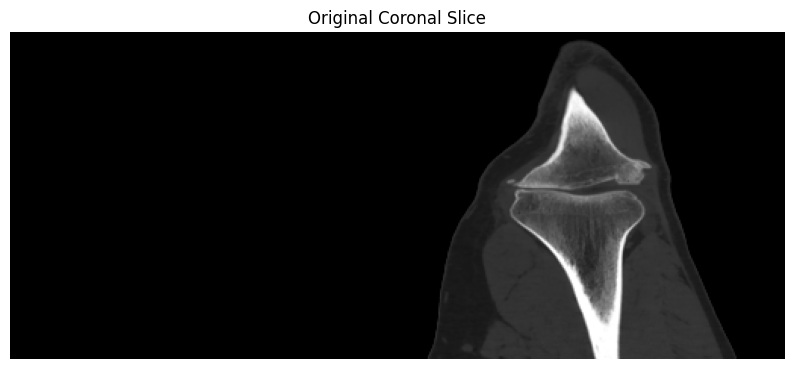

Segmenting knee CT...


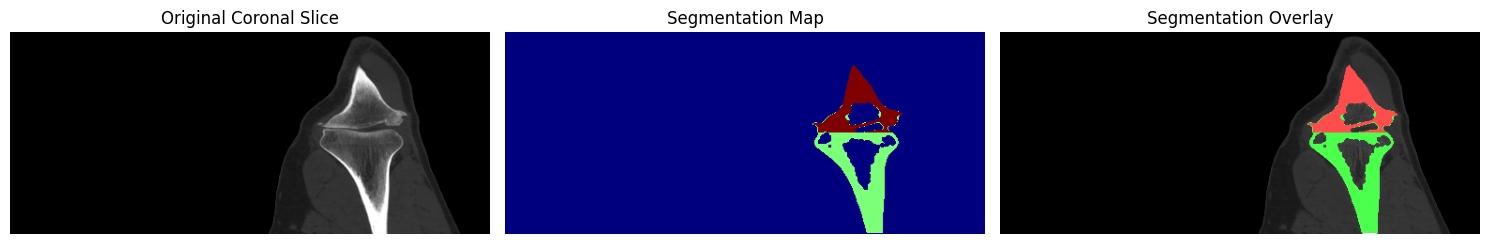

Segmentation saved to /content/drive/MyDrive/3702_left_knee_segmentation.nii.gz
Tibia volume: 274610 voxels (label 1, green)
Femur volume: 244016 voxels (label 2, red)


In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, morphology, measure, segmentation, feature

def segment_knee(input_path, output_path):
    """
    Segment the femur and tibia from a knee CT scan.

    Parameters:
    -----------
    input_path : str
        Path to the input NIfTI file
    output_path : str
        Path where the output segmentation should be saved

    Returns:
    --------
    numpy.ndarray
        The segmentation volume with labels: 0=background, 1=tibia, 2=femur
    """
    # Load the NIfTI file
    print(f"Loading image from {input_path}")
    img = nib.load(input_path)
    data = img.get_fdata()

    # Get image information
    print(f"Image shape: {data.shape}")
    print(f"Image data type: {data.dtype}")
    value_range = [np.min(data), np.max(data)]
    print(f"Value range: {value_range}")

    # Display original middle coronal slice
    coronal_idx = data.shape[1] // 2
    coronal_slice = data[:, coronal_idx, :]

    plt.figure(figsize=(10, 10))
    plt.imshow(coronal_slice.T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')
    plt.show()

    # Create empty segmentation volume
    segmentation_volume = np.zeros_like(data)

    # Set bone thresholds
    bone_threshold = 200

    # Process slices in the coronal plane (along y-axis)
    print("Segmenting knee CT...")

    # Focus on the central portion of the volume where the knee joint is
    start_slice = int(data.shape[1] * 0.2)
    end_slice = int(data.shape[1] * 0.8)

    # First pass segmentation
    for i in range(start_slice, end_slice):
        slice_data = data[:, i, :]

        # Skip slices with no significant bone content
        if np.max(slice_data) < bone_threshold:
            continue

        # Create bone mask
        bone_mask = slice_data > bone_threshold
        bone_mask = morphology.remove_small_objects(bone_mask, min_size=50)
        bone_mask = morphology.binary_closing(bone_mask, morphology.disk(2))

        # Get image height
        height = slice_data.shape[1]

        # Find approximate joint position by analyzing vertical bone profile
        vertical_profile = np.sum(bone_mask, axis=0)
        smooth_profile = ndimage.gaussian_filter1d(vertical_profile, sigma=5)

        # Look for minima in middle third of image
        middle_start = height // 3
        middle_end = 2 * height // 3
        middle_profile = smooth_profile[middle_start:middle_end]

        # Find local minima
        if len(middle_profile) > 5:
            min_indices = []
            for j in range(2, len(middle_profile) - 2):
                if middle_profile[j] < middle_profile[j-1] and middle_profile[j] < middle_profile[j+1]:
                    min_indices.append(j)

            if min_indices:
                # Find most significant minimum
                joint_idx = min_indices[np.argmin([middle_profile[j] for j in min_indices])]
                joint_position = middle_start + joint_idx

                # Create femur and tibia masks
                femur_mask = bone_mask.copy()
                femur_mask[:, joint_position:] = False

                tibia_mask = bone_mask.copy()
                tibia_mask[:, :joint_position] = False
            else:
                # If no joint found, use middle point
                mid_point = height // 2

                femur_mask = bone_mask.copy()
                femur_mask[:, mid_point:] = False

                tibia_mask = bone_mask.copy()
                tibia_mask[:, :mid_point] = False
        else:
            # Fallback to middle division
            mid_point = height // 2

            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False

            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False

        # Clean up masks
        femur_mask = morphology.remove_small_objects(femur_mask, min_size=100)
        tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=100)

        # Add to segmentation with CORRECT labels:
        # CRITICAL: Label 1 for tibia (will be green), Label 2 for femur (will be red)
        segmentation_volume[:, i, :][tibia_mask] = 1
        segmentation_volume[:, i, :][femur_mask] = 2

    # Apply 3D post-processing
    # Extract femur and tibia masks using the correct labels
    tibia_seg = segmentation_volume == 1
    femur_seg = segmentation_volume == 2

    # Morphological operations for smoother results
    struct_element = np.ones((3, 3, 3))

    # Fill holes
    tibia_seg = ndimage.binary_fill_holes(tibia_seg)
    femur_seg = ndimage.binary_fill_holes(femur_seg)

    # Smoothing
    tibia_seg = ndimage.binary_closing(tibia_seg, structure=struct_element)
    femur_seg = ndimage.binary_closing(femur_seg, structure=struct_element)

    # Remove small objects
    tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
    femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)

    # Reconstruct final segmentation
    segmentation_volume = np.zeros_like(data)
    segmentation_volume[tibia_seg] = 1  # Tibia (green)
    segmentation_volume[femur_seg] = 2  # Femur (red)

    # Check if segmentation was successful
    tibia_volume = np.sum(tibia_seg)
    femur_volume = np.sum(femur_seg)

    # Apply fallback method if needed
    if tibia_volume < 1000 or femur_volume < 1000:
        print("Warning: Insufficient bone volume detected. Applying fallback method...")

        # More aggressive bone segmentation
        segmentation_volume = np.zeros_like(data)

        for i in range(start_slice, end_slice):
            slice_data = data[:, i, :]

            # Lower threshold
            bone_mask = slice_data > 150

            # Split at middle
            height = slice_data.shape[1]
            mid_point = height // 2

            # Create femur and tibia masks
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            femur_mask = morphology.remove_small_objects(femur_mask, min_size=50)

            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False
            tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=50)

            # Add to segmentation - Tibia=1, Femur=2
            segmentation_volume[:, i, :][tibia_mask] = 1
            segmentation_volume[:, i, :][femur_mask] = 2

        # Reapply 3D post-processing
        tibia_seg = segmentation_volume == 1
        femur_seg = segmentation_volume == 2

        # Use larger structural elements
        tibia_seg = ndimage.binary_closing(tibia_seg, structure=np.ones((5, 5, 5)))
        femur_seg = ndimage.binary_closing(femur_seg, structure=np.ones((5, 5, 5)))

        tibia_seg = ndimage.binary_fill_holes(tibia_seg)
        femur_seg = ndimage.binary_fill_holes(femur_seg)

        tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
        femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)

        # Reconstruct final segmentation
        segmentation_volume = np.zeros_like(data)
        segmentation_volume[tibia_seg] = 1  # Tibia (green)
        segmentation_volume[femur_seg] = 2  # Femur (red)

    # Display segmentation results
    mid_slice = data.shape[1] // 2

    plt.figure(figsize=(15, 5))

    # Original slice
    plt.subplot(1, 3, 1)
    plt.imshow(data[:, mid_slice, :].T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')

    # Segmentation map
    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_volume[:, mid_slice, :].T, cmap='jet')
    plt.title('Segmentation Map')
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)

    # Create RGB overlay
    overlay = np.zeros((*data[:, mid_slice, :].T.shape, 3))

    # Normalize original image for background
    orig_slice = data[:, mid_slice, :].T
    orig_norm = np.clip(orig_slice, -300, 1500)
    orig_norm = (orig_norm - (-300)) / (1500 - (-300))

    # Set background grayscale
    overlay[:, :, 0] = orig_norm
    overlay[:, :, 1] = orig_norm
    overlay[:, :, 2] = orig_norm

    # Create masks for femur and tibia with CORRECT labels
    tibia_mask = segmentation_volume[:, mid_slice, :].T == 1
    femur_mask = segmentation_volume[:, mid_slice, :].T == 2

    # Set femur to RED (upper bone)
    overlay[femur_mask, 0] = 1.0  # Red
    overlay[femur_mask, 1] = 0.3  # Green
    overlay[femur_mask, 2] = 0.3  # Blue

    # Set tibia to GREEN (lower bone)
    overlay[tibia_mask, 0] = 0.3  # Red
    overlay[tibia_mask, 1] = 1.0  # Green
    overlay[tibia_mask, 2] = 0.3  # Blue

    plt.imshow(overlay)
    plt.title('Segmentation Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save segmentation as NIfTI file
    segmentation_nifti = nib.Nifti1Image(segmentation_volume.astype(np.int16), img.affine, img.header)
    segmentation_nifti.header.set_data_dtype(np.int16)
    nib.save(segmentation_nifti, output_path)
    print(f"Segmentation saved to {output_path}")

    # Report volumes
    tibia_volume = np.sum(segmentation_volume == 1)
    femur_volume = np.sum(segmentation_volume == 2)
    print(f"Tibia volume: {tibia_volume} voxels (label 1, green)")
    print(f"Femur volume: {femur_volume} voxels (label 2, red)")

    return segmentation_volume

# Main execution block
if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/3702_left_knee.nii.gz"
    output_path = "/content/drive/MyDrive/3702_left_knee_segmentation.nii.gz"

    # Check if input file exists
    if not os.path.exists(input_path):
        print(f"Error: Input file {input_path} does not exist.")
    else:
        # Perform segmentation
        segmentation = segment_knee(input_path, output_path)

Loading image from /content/drive/MyDrive/3702_left_knee.nii.gz
Image shape: (512, 512, 216)
Image data type: float64
Value range: [np.float64(-3024.0), np.float64(1769.0)]


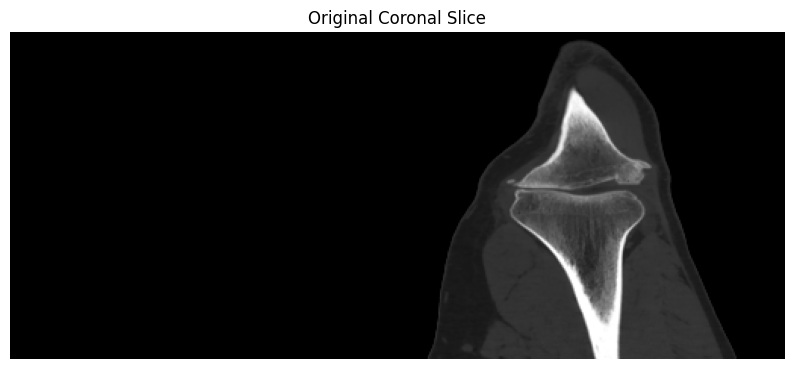

Segmenting knee CT...
Expanding segmentation masks by 2.0 mm...
Voxel spacing: [0.86914098 0.86914098 2.        ] mm
Expansion radius in voxels: [2.30112265 2.30112265 1.        ]


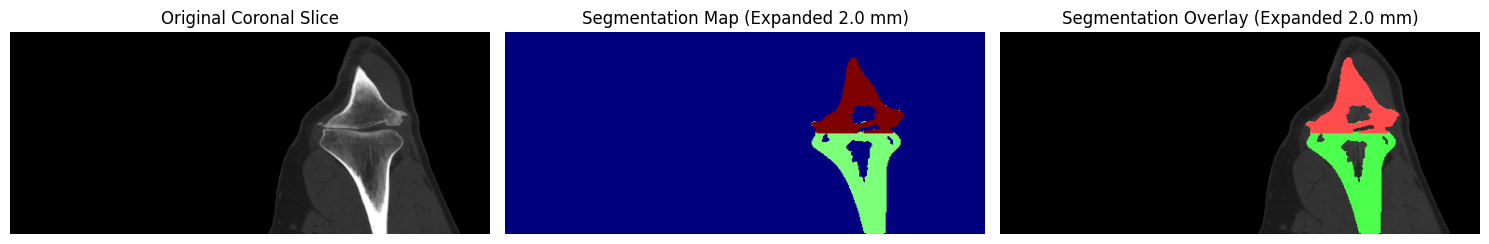

Expanded segmentation saved to /content/drive/MyDrive/3702_left_knee_segmentation_expanded.nii.gz
Tibia volume (expanded): 460855 voxels (label 1, green)
Femur volume (expanded): 461878 voxels (label 2, red)


In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, morphology, measure, segmentation, feature

def create_spherical_structuring_element(radius_voxels, voxel_spacing):
    """Create a 3D spherical structuring element for dilation based on mm radius."""
    # Compute radius in voxels for each dimension
    radius_voxels = np.array(radius_voxels)
    # Create a grid to evaluate the sphere
    max_radius = int(np.ceil(np.max(radius_voxels)))
    grid = np.zeros((2 * max_radius + 1, 2 * max_radius + 1, 2 * max_radius + 1), dtype=bool)
    center = max_radius
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            for k in range(grid.shape[2]):
                # Compute distance in mm
                mm_coords = np.array([(i - center) * voxel_spacing[0],
                                      (j - center) * voxel_spacing[1],
                                      (k - center) * voxel_spacing[2]])
                distance_mm = np.sqrt(np.sum(mm_coords ** 2))
                if distance_mm <= radius_voxels[0]:  # Use x-axis radius as reference
                    grid[i, j, k] = True
    return grid

def expand_segmentation(segmentation_volume, img, expansion_mm=2.0):
    """Expand tibia and femur masks by a specified distance in mm."""
    # Get voxel spacing from the affine matrix
    voxel_spacing = np.abs(np.diag(img.affine)[:3])  # mm per voxel in x, y, z
    print(f"Voxel spacing: {voxel_spacing} mm")

    # Convert expansion distance to voxels
    radius_voxels = expansion_mm / voxel_spacing
    print(f"Expansion radius in voxels: {radius_voxels}")

    # Create spherical structuring element
    struct_element = create_spherical_structuring_element(radius_voxels, voxel_spacing)

    # Extract tibia and femur masks
    tibia_mask = segmentation_volume == 1
    femur_mask = segmentation_volume == 2

    # Expand masks using binary dilation
    expanded_tibia = ndimage.binary_dilation(tibia_mask, structure=struct_element)
    expanded_femur = ndimage.binary_dilation(femur_mask, structure=struct_element)

    # Handle overlaps: prioritize femur (label 2) in overlapping regions
    overlap = expanded_tibia & expanded_femur
    expanded_tibia[overlap] = False  # Remove tibia from overlap regions

    # Reconstruct segmentation volume
    expanded_volume = np.zeros_like(segmentation_volume)
    expanded_volume[expanded_tibia] = 1  # Tibia
    expanded_volume[expanded_femur] = 2  # Femur

    return expanded_volume

def segment_knee(input_path, output_path, expansion_mm=2.0):
    """
    Segment the femur and tibia from a knee CT scan and expand the masks.

    Parameters:
    -----------
    input_path : str
        Path to the input NIfTI file
    output_path : str
        Path where the output segmentation should be saved
    expansion_mm : float, optional
        Distance in mm to expand the segmentation masks (default: 2.0)

    Returns:
    --------
    numpy.ndarray
        The expanded segmentation volume with labels: 0=background, 1=tibia, 2=femur
    """
    # Load the NIfTI file
    print(f"Loading image from {input_path}")
    img = nib.load(input_path)
    data = img.get_fdata()

    # Get image information
    print(f"Image shape: {data.shape}")
    print(f"Image data type: {data.dtype}")
    value_range = [np.min(data), np.max(data)]
    print(f"Value range: {value_range}")

    # Display original middle coronal slice
    coronal_idx = data.shape[1] // 2
    coronal_slice = data[:, coronal_idx, :]

    plt.figure(figsize=(10, 10))
    plt.imshow(coronal_slice.T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')
    plt.show()

    # Create empty segmentation volume
    segmentation_volume = np.zeros_like(data)

    # Set bone thresholds
    bone_threshold = 200

    # Process slices in the coronal plane (along y-axis)
    print("Segmenting knee CT...")

    # Focus on the central portion of the volume where the knee joint is
    start_slice = int(data.shape[1] * 0.2)
    end_slice = int(data.shape[1] * 0.8)

    # First pass segmentation
    for i in range(start_slice, end_slice):
        slice_data = data[:, i, :]

        # Skip slices with no significant bone content
        if np.max(slice_data) < bone_threshold:
            continue

        # Create bone mask
        bone_mask = slice_data > bone_threshold
        bone_mask = morphology.remove_small_objects(bone_mask, min_size=50)
        bone_mask = morphology.binary_closing(bone_mask, morphology.disk(2))

        # Get image height
        height = slice_data.shape[1]

        # Find approximate joint position by analyzing vertical bone profile
        vertical_profile = np.sum(bone_mask, axis=0)
        smooth_profile = ndimage.gaussian_filter1d(vertical_profile, sigma=5)

        # Look for minima in middle third of image
        middle_start = height // 3
        middle_end = 2 * height // 3
        middle_profile = smooth_profile[middle_start:middle_end]

        # Find local minima
        if len(middle_profile) > 5:
            min_indices = []
            for j in range(2, len(middle_profile) - 2):
                if middle_profile[j] < middle_profile[j-1] and middle_profile[j] < middle_profile[j+1]:
                    min_indices.append(j)

            if min_indices:
                # Find most significant minimum
                joint_idx = min_indices[np.argmin([middle_profile[j] for j in min_indices])]
                joint_position = middle_start + joint_idx

                # Create femur and tibia masks
                femur_mask = bone_mask.copy()
                femur_mask[:, joint_position:] = False

                tibia_mask = bone_mask.copy()
                tibia_mask[:, :joint_position] = False
            else:
                # If no joint found, use middle point
                mid_point = height // 2

                femur_mask = bone_mask.copy()
                femur_mask[:, mid_point:] = False

                tibia_mask = bone_mask.copy()
                tibia_mask[:, :mid_point] = False
        else:
            # Fallback to middle division
            mid_point = height // 2

            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False

            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False

        # Clean up masks
        femur_mask = morphology.remove_small_objects(femur_mask, min_size=100)
        tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=100)

        # Add to segmentation with CORRECT labels:
        # CRITICAL: Label 1 for tibia (will be green), Label 2 for femur (will be red)
        segmentation_volume[:, i, :][tibia_mask] = 1
        segmentation_volume[:, i, :][femur_mask] = 2

    # Apply 3D post-processing
    # Extract femur and tibia masks using the correct labels
    tibia_seg = segmentation_volume == 1
    femur_seg = segmentation_volume == 2

    # Morphological operations for smoother results
    struct_element = np.ones((3, 3, 3))

    # Fill holes
    tibia_seg = ndimage.binary_fill_holes(tibia_seg)
    femur_seg = ndimage.binary_fill_holes(femur_seg)

    # Smoothing
    tibia_seg = ndimage.binary_closing(tibia_seg, structure=struct_element)
    femur_seg = ndimage.binary_closing(femur_seg, structure=struct_element)

    # Remove small objects
    tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
    femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)

    # Reconstruct final segmentation
    segmentation_volume = np.zeros_like(data)
    segmentation_volume[tibia_seg] = 1  # Tibia (green)
    segmentation_volume[femur_seg] = 2  # Femur (red)

    # Check if segmentation was successful
    tibia_volume = np.sum(tibia_seg)
    femur_volume = np.sum(femur_seg)

    # Apply fallback method if needed
    if tibia_volume < 1000 or femur_volume < 1000:
        print("Warning: Insufficient bone volume detected. Applying fallback method...")

        # More aggressive bone segmentation
        segmentation_volume = np.zeros_like(data)

        for i in range(start_slice, end_slice):
            slice_data = data[:, i, :]

            # Lower threshold
            bone_mask = slice_data > 150

            # Split at middle
            height = slice_data.shape[1]
            mid_point = height // 2

            # Create femur and tibia masks
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            femur_mask = morphology.remove_small_objects(femur_mask, min_size=50)

            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False
            tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=50)

            # Add to segmentation - Tibia=1, Femur=2
            segmentation_volume[:, i, :][tibia_mask] = 1
            segmentation_volume[:, i, :][femur_mask] = 2

        # Reapply 3D post-processing
        tibia_seg = segmentation_volume == 1
        femur_seg = segmentation_volume == 2

        # Use larger structural elements
        tibia_seg = ndimage.binary_closing(tibia_seg, structure=np.ones((5, 5, 5)))
        femur_seg = ndimage.binary_closing(femur_seg, structure=np.ones((5, 5, 5)))

        tibia_seg = ndimage.binary_fill_holes(tibia_seg)
        femur_seg = ndimage.binary_fill_holes(femur_seg)

        tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
        femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)

        # Reconstruct final segmentation
        segmentation_volume = np.zeros_like(data)
        segmentation_volume[tibia_seg] = 1  # Tibia (green)
        segmentation_volume[femur_seg] = 2  # Femur (red)

    # Expand the segmentation masks
    print(f"Expanding segmentation masks by {expansion_mm} mm...")
    segmentation_volume = expand_segmentation(segmentation_volume, img, expansion_mm=expansion_mm)

    # Display segmentation results
    mid_slice = data.shape[1] // 2

    plt.figure(figsize=(15, 5))

    # Original slice
    plt.subplot(1, 3, 1)
    plt.imshow(data[:, mid_slice, :].T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')

    # Segmentation map
    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_volume[:, mid_slice, :].T, cmap='jet')
    plt.title(f'Segmentation Map (Expanded {expansion_mm} mm)')
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)

    # Create RGB overlay
    overlay = np.zeros((*data[:, mid_slice, :].T.shape, 3))

    # Normalize original image for background
    orig_slice = data[:, mid_slice, :].T
    orig_norm = np.clip(orig_slice, -300, 1500)
    orig_norm = (orig_norm - (-300)) / (1500 - (-300))

    # Set background grayscale
    overlay[:, :, 0] = orig_norm
    overlay[:, :, 1] = orig_norm
    overlay[:, :, 2] = orig_norm

    # Create masks for femur and tibia with CORRECT labels
    tibia_mask = segmentation_volume[:, mid_slice, :].T == 1
    femur_mask = segmentation_volume[:, mid_slice, :].T == 2

    # Set femur to RED (upper bone)
    overlay[femur_mask, 0] = 1.0  # Red
    overlay[femur_mask, 1] = 0.3  # Green
    overlay[femur_mask, 2] = 0.3  # Blue

    # Set tibia to GREEN (lower bone)
    overlay[tibia_mask, 0] = 0.3  # Red
    overlay[tibia_mask, 1] = 1.0  # Green
    overlay[tibia_mask, 2] = 0.3  # Blue

    plt.imshow(overlay)
    plt.title(f'Segmentation Overlay (Expanded {expansion_mm} mm)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save segmentation as NIfTI file
    segmentation_nifti = nib.Nifti1Image(segmentation_volume.astype(np.int16), img.affine, img.header)
    segmentation_nifti.header.set_data_dtype(np.int16)
    nib.save(segmentation_nifti, output_path)
    print(f"Expanded segmentation saved to {output_path}")

    # Report volumes
    tibia_volume = np.sum(segmentation_volume == 1)
    femur_volume = np.sum(segmentation_volume == 2)
    print(f"Tibia volume (expanded): {tibia_volume} voxels (label 1, green)")
    print(f"Femur volume (expanded): {femur_volume} voxels (label 2, red)")

    return segmentation_volume

# Main execution block
if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/3702_left_knee.nii.gz"
    output_path = "/content/drive/MyDrive/3702_left_knee_segmentation_expanded.nii.gz"

    # Check if input file exists
    if not os.path.exists(input_path):
        print(f"Error: Input file {input_path} does not exist.")
    else:
        # Perform segmentation with expansion
        segmentation = segment_knee(input_path, output_path, expansion_mm=2.0)

Loading image from /content/drive/MyDrive/3702_left_knee.nii.gz
Image shape: (512, 512, 216)
Image data type: float64
Value range: [np.float64(-3024.0), np.float64(1769.0)]


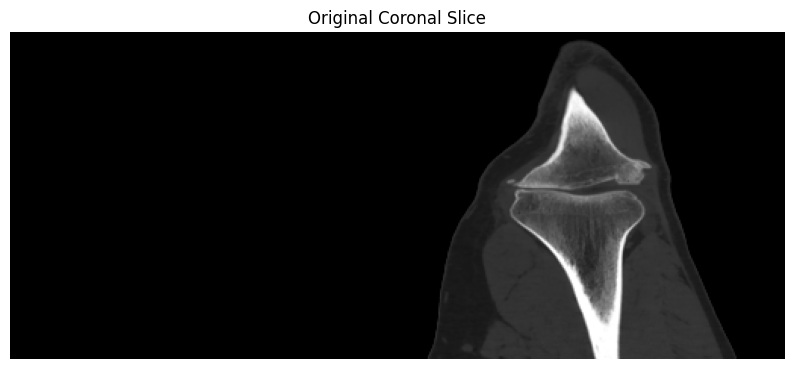

Segmenting knee CT...
Expanding segmentation masks by 2.0 mm...
Voxel spacing: [0.86914098 0.86914098 2.        ] mm
Expansion radius in voxels: [2.30112265 2.30112265 1.        ]
Randomizing segmentation with random_factor=0.5...


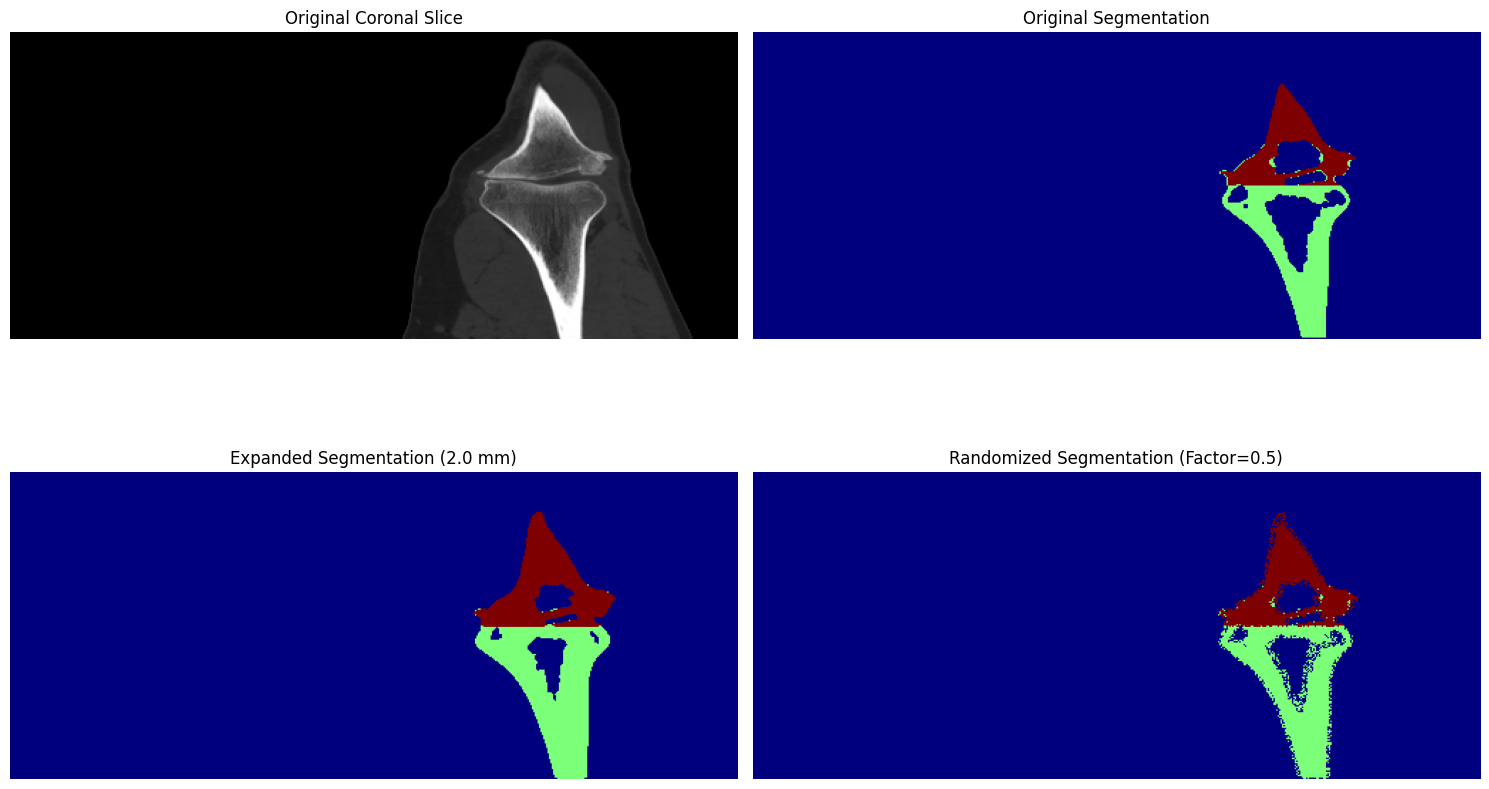

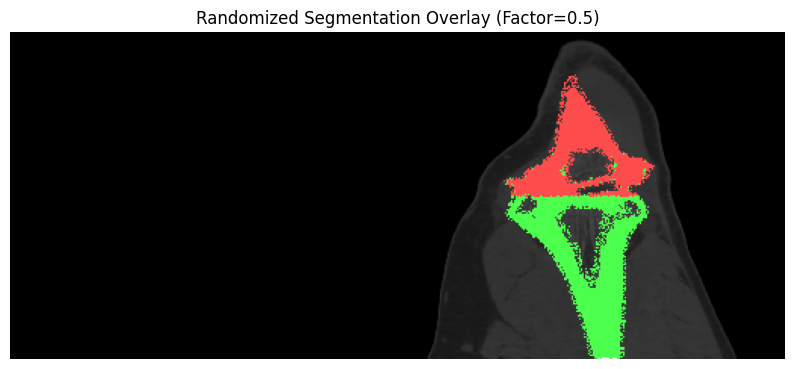

Randomized segmentation saved to /content/drive/MyDrive/3702_left_knee_segmentation_randomized.nii.gz
Original Tibia volume: 274610 voxels (label 1, green)
Original Femur volume: 244016 voxels (label 2, red)
Expanded Tibia volume: 460855 voxels (label 1, green)
Expanded Femur volume: 461878 voxels (label 2, red)
Randomized Tibia volume: 367856 voxels (label 1, green)
Randomized Femur volume: 352907 voxels (label 2, red, RandomFactor=0.5)


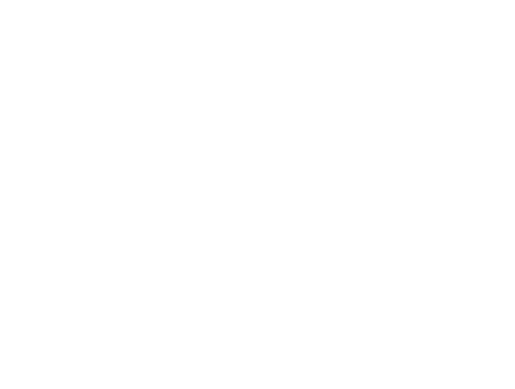

Randomized segmentation saved to /content/drive/MyDrive/3702_left_knee_segmentation_randomized.nii.gz
Original Tibia volume: 274610 voxels (label 1, green)
Original Femur volume: 244016 voxels (label 2, red)
Expanded Tibia volume: 460855 voxels (label 1, green)
Expanded Femur volume: 461878 voxels (label 1, green)
Randomized Tibia volume: 367856 voxels (label 1, green)
Randomized Femur volume: 352907 voxels (label 2, red)


In [7]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, morphology, measure, segmentation, feature

def create_spherical_structuring_element(radius_voxels, voxel_spacing):
    """Create a 3D spherical structuring element for dilation based on mm radius."""
    radius_voxels = np.array(radius_voxels)
    max_radius = int(np.ceil(np.max(radius_voxels)))
    grid = np.zeros((2 * max_radius + 1, 2 * max_radius + 1, 2 * max_radius + 1), dtype=bool)
    center = max_radius
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            for k in range(grid.shape[2]):
                mm_coords = np.array([(i - center) * voxel_spacing[0],
                                      (j - center) * voxel_spacing[1],
                                      (k - center) * voxel_spacing[2]])
                distance_mm = np.sqrt(np.sum(mm_coords ** 2))
                if distance_mm <= radius_voxels[0]:
                    grid[i, j, k] = True
    return grid

def expand_segmentation(segmentation_volume, img, expansion_mm=2.0):
    """Expand tibia and femur masks by a specified distance in mm."""
    voxel_spacing = np.abs(np.diag(img.affine)[:3])
    print(f"Voxel spacing: {voxel_spacing} mm")
    radius_voxels = expansion_mm / voxel_spacing
    print(f"Expansion radius in voxels: {radius_voxels}")
    struct_element = create_spherical_structuring_element(radius_voxels, voxel_spacing)
    tibia_mask = segmentation_volume == 1
    femur_mask = segmentation_volume == 2
    expanded_tibia = ndimage.binary_dilation(tibia_mask, structure=struct_element)
    expanded_femur = ndimage.binary_dilation(femur_mask, structure=struct_element)
    overlap = expanded_tibia & expanded_femur
    expanded_tibia[overlap] = False
    expanded_volume = np.zeros_like(segmentation_volume)
    expanded_volume[expanded_tibia] = 1
    expanded_volume[expanded_femur] = 2
    return expanded_volume

def randomize_segmentation(original_volume, expanded_volume, random_factor=0.5):
    """Create a randomized mask between original and expanded masks."""
    if not 0 <= random_factor <= 1:
        raise ValueError("random_factor must be between 0 and 1")

    randomized_volume = np.copy(original_volume)

    for label in [1, 2]:  # Tibia (1), Femur (2)
        original_mask = original_volume == label
        expanded_mask = expanded_volume == label
        intermediate_region = expanded_mask & ~original_mask

        # Randomly select voxels from the intermediate region
        random_mask = np.random.random(intermediate_region.shape) < random_factor
        selected_intermediate = intermediate_region & random_mask

        # Add selected intermediate voxels to the randomized mask
        randomized_volume[selected_intermediate] = label

    # Ensure no overlaps between tibia and femur
    tibia_mask = randomized_volume == 1
    femur_mask = randomized_volume == 2
    overlap = tibia_mask & femur_mask
    tibia_mask[overlap] = False  # Prioritize femur in overlaps
    randomized_volume = np.zeros_like(original_volume)
    randomized_volume[tibia_mask] = 1
    randomized_volume[femur_mask] = 2

    return randomized_volume

def segment_knee(input_path, output_path, expansion_mm=2.0, random_factor=0.5):
    """
    Segment femur and tibia from a knee CT scan, expand, and randomize the mask.

    Parameters:
    -----------
    input_path : str
        Path to the input NIfTI file
    output_path : str
        Path where the output segmentation should be saved
    expansion_mm : float, optional
        Distance in mm to expand the segmentation masks (default: 2.0)
    random_factor : float, optional
        Probability of including intermediate voxels (0 to 1, default: 0.5)

    Returns:
    --------
    numpy.ndarray
        The randomized segmentation volume with labels: 0=background, 1=tibia, 2=femur
    """
    # Load the NIfTI file
    print(f"Loading image from {input_path}")
    img = nib.load(input_path)
    data = img.get_fdata()

    # Get image information
    print(f"Image shape: {data.shape}")
    print(f"Image data type: {data.dtype}")
    value_range = [np.min(data), np.max(data)]
    print(f"Value range: {value_range}")

    # Display original middle coronal slice
    coronal_idx = data.shape[1] // 2
    coronal_slice = data[:, coronal_idx, :]

    plt.figure(figsize=(10, 10))
    plt.imshow(coronal_slice.T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')
    plt.show()

    # Create empty segmentation volume
    segmentation_volume = np.zeros_like(data)

    # Set bone thresholds
    bone_threshold = 200

    # Process slices in the coronal plane (along y-axis)
    print("Segmenting knee CT...")

    # Focus on the central portion of the volume where the knee joint is
    start_slice = int(data.shape[1] * 0.2)
    end_slice = int(data.shape[1] * 0.8)

    # First pass segmentation
    for i in range(start_slice, end_slice):
        slice_data = data[:, i, :]

        # Skip slices with no significant bone content
        if np.max(slice_data) < bone_threshold:
            continue

        # Create bone mask
        bone_mask = slice_data > bone_threshold
        bone_mask = morphology.remove_small_objects(bone_mask, min_size=50)
        bone_mask = morphology.binary_closing(bone_mask, morphology.disk(2))

        # Get image height
        height = slice_data.shape[1]

        # Find approximate joint position by analyzing vertical bone profile
        vertical_profile = np.sum(bone_mask, axis=0)
        smooth_profile = ndimage.gaussian_filter1d(vertical_profile, sigma=5)

        # Look for minima in middle third of image
        middle_start = height // 3
        middle_end = 2 * height // 3
        middle_profile = smooth_profile[middle_start:middle_end]

        # Find local minima
        if len(middle_profile) > 5:
            min_indices = []
            for j in range(2, len(middle_profile) - 2):
                if middle_profile[j] < middle_profile[j-1] and middle_profile[j] < middle_profile[j+1]:
                    min_indices.append(j)

            if min_indices:
                joint_idx = min_indices[np.argmin([middle_profile[j] for j in min_indices])]
                joint_position = middle_start + joint_idx

                femur_mask = bone_mask.copy()
                femur_mask[:, joint_position:] = False

                tibia_mask = bone_mask.copy()
                tibia_mask[:, :joint_position] = False
            else:
                mid_point = height // 2
                femur_mask = bone_mask.copy()
                femur_mask[:, mid_point:] = False
                tibia_mask = bone_mask.copy()
                tibia_mask[:, :mid_point] = False
        else:
            mid_point = height // 2
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False

        femur_mask = morphology.remove_small_objects(femur_mask, min_size=100)
        tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=100)

        segmentation_volume[:, i, :][tibia_mask] = 1
        segmentation_volume[:, i, :][femur_mask] = 2

    # Apply 3D post-processing
    tibia_seg = segmentation_volume == 1
    femur_seg = segmentation_volume == 2
    struct_element = np.ones((3, 3, 3))
    tibia_seg = ndimage.binary_fill_holes(tibia_seg)
    femur_seg = ndimage.binary_fill_holes(femur_seg)
    tibia_seg = ndimage.binary_closing(tibia_seg, structure=struct_element)
    femur_seg = ndimage.binary_closing(femur_seg, structure=struct_element)
    tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
    femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)
    segmentation_volume = np.zeros_like(data)
    segmentation_volume[tibia_seg] = 1
    segmentation_volume[femur_seg] = 2

    # Check if segmentation was successful
    tibia_volume = np.sum(tibia_seg)
    femur_volume = np.sum(femur_seg)

    # Apply fallback method if needed
    if tibia_volume < 1000 or femur_volume < 1000:
        print("Warning: Insufficient bone volume detected. Applying fallback method...")
        segmentation_volume = np.zeros_like(data)
        for i in range(start_slice, end_slice):
            slice_data = data[:, i, :]
            bone_mask = slice_data > 150
            height = slice_data.shape[1]
            mid_point = height // 2
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            femur_mask = morphology.remove_small_objects(femur_mask, min_size=50)
            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False
            tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=50)
            segmentation_volume[:, i, :][tibia_mask] = 1
            segmentation_volume[:, i, :][femur_mask] = 2
        tibia_seg = segmentation_volume == 1
        femur_seg = segmentation_volume == 2
        tibia_seg = ndimage.binary_closing(tibia_seg, structure=np.ones((5, 5, 5)))
        femur_seg = ndimage.binary_closing(femur_seg, structure=np.ones((5, 5, 5)))
        tibia_seg = ndimage.binary_fill_holes(tibia_seg)
        femur_seg = ndimage.binary_fill_holes(femur_seg)
        tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
        femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)
        segmentation_volume = np.zeros_like(data)
        segmentation_volume[tibia_seg] = 1
        segmentation_volume[femur_seg] = 2

    # Store original segmentation for randomization
    original_volume = np.copy(segmentation_volume)

    # Expand the segmentation masks
    print(f"Expanding segmentation masks by {expansion_mm} mm...")
    expanded_volume = expand_segmentation(segmentation_volume, img, expansion_mm=expansion_mm)

    # Randomize the segmentation
    print(f"Randomizing segmentation with random_factor={random_factor}...")
    segmentation_volume = randomize_segmentation(original_volume, expanded_volume, random_factor=random_factor)

    # Display segmentation results
    mid_slice = data.shape[1] // 2
    plt.figure(figsize=(15, 10))

    # Original slice
    plt.subplot(2, 2, 1)
    plt.imshow(data[:, mid_slice, :].T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')

    # Original segmentation
    plt.subplot(2, 2, 2)
    plt.imshow(original_volume[:, mid_slice, :].T, cmap='jet')
    plt.title('Original Segmentation')
    plt.axis('off')

    # Expanded segmentation
    plt.subplot(2, 2, 3)
    plt.imshow(expanded_volume[:, mid_slice, :].T, cmap='jet')
    plt.title(f'Expanded Segmentation ({expansion_mm} mm)')
    plt.axis('off')

    # Randomized segmentation
    plt.subplot(2, 2, 4)
    plt.imshow(segmentation_volume[:, mid_slice, :].T, cmap='jet')
    plt.title(f'Randomized Segmentation (Factor={random_factor})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Display overlay for randomized segmentation
    plt.figure(figsize=(10, 10))
    overlay = np.zeros((*data[:, mid_slice, :].T.shape, 3))
    orig_slice = data[:, mid_slice, :].T
    orig_norm = np.clip(orig_slice, -300, 1500)
    orig_norm = (orig_norm - (-300)) / (1500 - (-300))
    overlay[:, :, 0] = orig_norm
    overlay[:, :, 1] = orig_norm
    overlay[:, :, 2] = orig_norm
    tibia_mask = segmentation_volume[:, mid_slice, :].T == 1
    femur_mask = segmentation_volume[:, mid_slice, :].T == 2
    overlay[femur_mask, 0] = 1.0
    overlay[femur_mask, 1] = 0.3
    overlay[femur_mask, 2] = 0.3
    overlay[tibia_mask, 0] = 0.3
    overlay[tibia_mask, 1] = 1.0
    overlay[tibia_mask, 2] = 0.3
    plt.imshow(overlay)
    plt.title(f'Randomized Segmentation Overlay (Factor={random_factor})')
    plt.axis('off')
    plt.show()

    # Save segmentation as NIfTI file
    segmentation_nifti = nib.Nifti1Image(segmentation_volume.astype(np.int16), img.affine, img.header)
    segmentation_nifti.header.set_data_dtype(np.int16)
    nib.save(segmentation_nifti, output_path)
    print(f"Randomized segmentation saved to {output_path}")

    # Report volumes
    tibia_volume_orig = np.sum(original_volume == 1)
    femur_volume_orig = np.sum(original_volume == 2)
    tibia_volume_exp = np.sum(expanded_volume == 1)
    femur_volume_exp = np.sum(expanded_volume == 2)
    tibia_volume_rand = np.sum(segmentation_volume == 1)
    femur_volume_rand = np.sum(segmentation_volume == 2)
    print(f"Original Tibia volume: {tibia_volume_orig} voxels (label 1, green)")
    print(f"Original Femur volume: {femur_volume_orig} voxels (label 2, red)")
    print(f"Expanded Tibia volume: {tibia_volume_exp} voxels (label 1, green)")
    print(f"Expanded Femur volume: {femur_volume_exp} voxels (label 2, red)")
    print(f"Randomized Tibia volume: {tibia_volume_rand} voxels (label 1, green)")
    print(f"Randomized Femur volume: {femur_volume_rand} voxels (label 2, red, RandomFactor={random_factor})")
    plt.axis('off')
    plt.show()

    # Save segmentation as NIfTI file
    segmentation_nifti = nib.Nifti1Image(segmentation_volume.astype(np.int16), img.affine, img.header)
    segmentation_nifti.header.set_data_dtype(np.int16)
    nib.save(segmentation_nifti, output_path)
    print(f"Randomized segmentation saved to {output_path}")

    # Report volumes
    tibia_volume_orig = np.sum(original_volume == 1)
    femur_volume_orig = np.sum(original_volume == 2)
    tibia_volume_exp = np.sum(expanded_volume == 1)
    femur_volume_exp = np.sum(expanded_volume == 2)
    tibia_volume_rand = np.sum(segmentation_volume == 1)
    femur_volume_rand = np.sum(segmentation_volume == 2)
    print(f"Original Tibia volume: {tibia_volume_orig} voxels (label 1, green)")
    print(f"Original Femur volume: {femur_volume_orig} voxels (label 2, red)")
    print(f"Expanded Tibia volume: {tibia_volume_exp} voxels (label 1, green)")
    print(f"Expanded Femur volume: {femur_volume_exp} voxels (label 1, green)")
    print(f"Randomized Tibia volume: {tibia_volume_rand} voxels (label 1, green)")
    print(f"Randomized Femur volume: {femur_volume_rand} voxels (label 2, red)")

    return segmentation_volume

# Main execution block
if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/3702_left_knee.nii.gz"
    output_path = "/content/drive/MyDrive/3702_left_knee_segmentation_randomized.nii.gz"

    # Check if input file exists
    if not os.path.exists(input_path):
        print(f"Error: Input file {input_path} does not exist.")
    else:
        # Perform segmentation with expansion and randomization
        segmentation = segment_knee(input_path, output_path, expansion_mm=2.0, random_factor=0.5)

Loading image from /content/drive/MyDrive/3702_left_knee.nii.gz
Image shape: (512, 512, 216)
Image data type: float64
Value range: [np.float64(-3024.0), np.float64(1769.0)]
Segmenting knee CT...
Voxel spacing: [0.86914098 0.86914098 2.        ] mm
Expansion radius in voxels: [2.30112265 2.30112265 1.        ]
Voxel spacing: [0.86914098 0.86914098 2.        ] mm
Expansion radius in voxels: [4.6022453 4.6022453 2.       ]
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_original.nii.gz
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_expanded_2mm.nii.gz
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_expanded_4mm.nii.gz
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_randomized_1.nii.gz
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_randomized_2.nii.gz


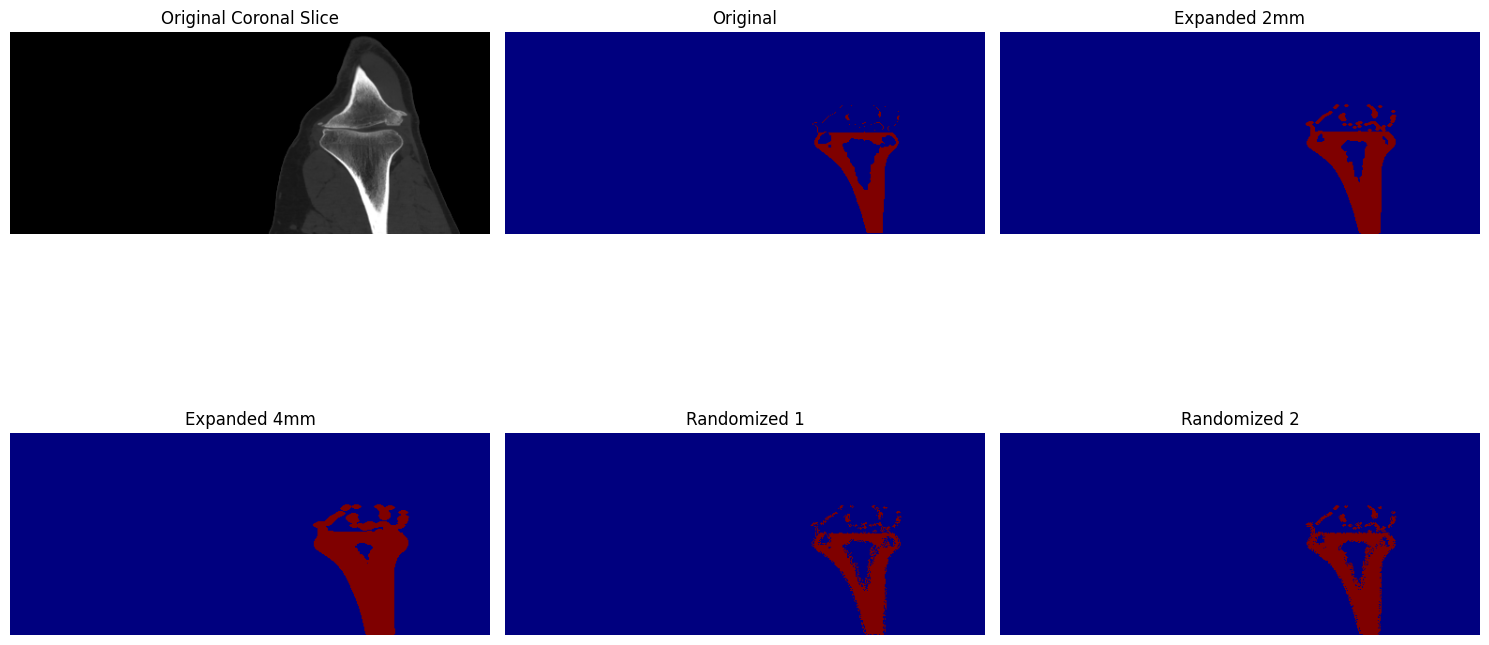

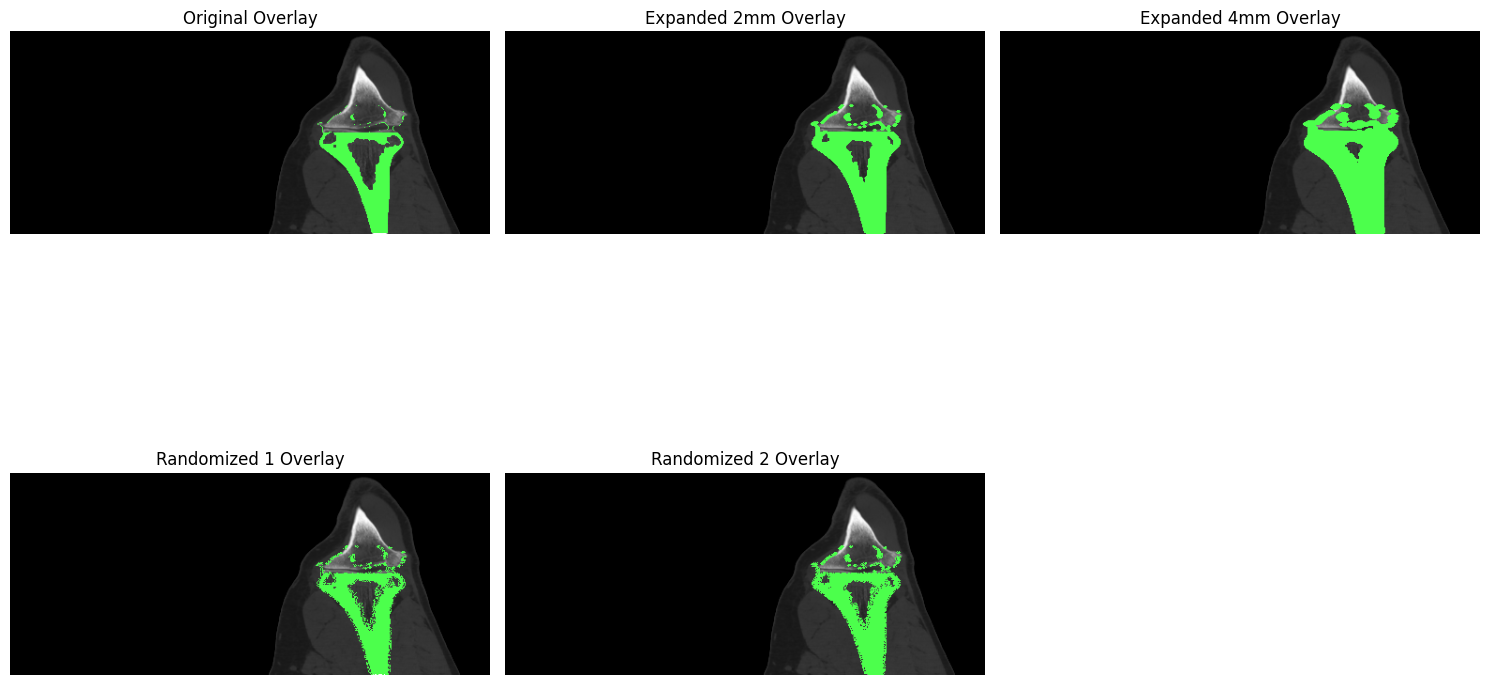

Original Tibia volume: 274610 voxels
Original Medial Lowest Point: [372 390 215]
Original Lateral Lowest Point: [255 402 215]
Expanded 2mm Tibia volume: 482253 voxels
Expanded 2mm Medial Lowest Point: [372 388 215]
Expanded 2mm Lateral Lowest Point: [253 401 215]
Expanded 4mm Tibia volume: 764361 voxels
Expanded 4mm Medial Lowest Point: [372 385 215]
Expanded 4mm Lateral Lowest Point: [250 401 215]
Randomized 1 Tibia volume: 378021 voxels
Randomized 1 Medial Lowest Point: [372 388 215]
Randomized 1 Lateral Lowest Point: [253 401 215]
Randomized 2 Tibia volume: 430272 voxels
Randomized 2 Medial Lowest Point: [372 388 215]
Randomized 2 Lateral Lowest Point: [253 401 215]


In [9]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, morphology, measure, feature

def create_spherical_structuring_element(radius_voxels, voxel_spacing):
    """Create a 3D spherical structuring element for dilation based on mm radius."""
    radius_voxels = np.array(radius_voxels)
    max_radius = int(np.ceil(np.max(radius_voxels)))
    grid = np.zeros((2 * max_radius + 1, 2 * max_radius + 1, 2 * max_radius + 1), dtype=bool)
    center = max_radius
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            for k in range(grid.shape[2]):
                mm_coords = np.array([(i - center) * voxel_spacing[0],
                                      (j - center) * voxel_spacing[1],
                                      (k - center) * voxel_spacing[2]])
                distance_mm = np.sqrt(np.sum(mm_coords ** 2))
                if distance_mm <= radius_voxels[0]:
                    grid[i, j, k] = True
    return grid

def expand_segmentation(segmentation_volume, img, expansion_mm=2.0, tibia_only=True):
    """Expand tibia mask by a specified distance in mm."""
    voxel_spacing = np.abs(np.diag(img.affine)[:3])
    print(f"Voxel spacing: {voxel_spacing} mm")
    radius_voxels = expansion_mm / voxel_spacing
    print(f"Expansion radius in voxels: {radius_voxels}")
    struct_element = create_spherical_structuring_element(radius_voxels, voxel_spacing)
    tibia_mask = segmentation_volume == 1
    expanded_tibia = ndimage.binary_dilation(tibia_mask, structure=struct_element)
    expanded_volume = np.zeros_like(segmentation_volume)
    expanded_volume[expanded_tibia] = 1
    return expanded_volume

def randomize_segmentation(original_volume, expanded_volume, random_factor=0.5, tibia_only=True):
    """Create a randomized tibia mask between original and expanded masks."""
    if not 0 <= random_factor <= 1:
        raise ValueError("random_factor must be between 0 and 1")

    randomized_volume = np.copy(original_volume)

    original_mask = original_volume == 1
    expanded_mask = expanded_volume == 1
    intermediate_region = expanded_mask & ~original_mask

    random_mask = np.random.random(intermediate_region.shape) < random_factor
    selected_intermediate = intermediate_region & random_mask

    randomized_volume[selected_intermediate] = 1

    return randomized_volume

def find_tibia_lowest_points(tibia_mask):
    """Find medial and lateral lowest points on the tibial surface."""
    # Extract surface using edge detection
    surface = filters.sobel(tibia_mask) > 0
    surface_coords = np.where(surface)
    surface_points = np.array(list(zip(surface_coords[0], surface_coords[1], surface_coords[2])))

    if len(surface_points) == 0:
        return None, None

    # Split into medial and lateral based on x-coordinate (left knee)
    x_coords = surface_points[:, 0]
    x_mid = (x_coords.min() + x_coords.max()) / 2
    medial_points = surface_points[x_coords >= x_mid]
    lateral_points = surface_points[x_coords < x_mid]

    # Find lowest (highest z) points
    medial_lowest = None
    lateral_lowest = None

    if len(medial_points) > 0:
        medial_lowest_idx = np.argmax(medial_points[:, 2])
        medial_lowest = medial_points[medial_lowest_idx]

    if len(lateral_points) > 0:
        lateral_lowest_idx = np.argmax(lateral_points[:, 2])
        lateral_lowest = lateral_points[lateral_lowest_idx]

    return medial_lowest, lateral_lowest

def save_nifti(volume, affine, header, output_path):
    """Save a volume as a NIfTI file."""
    nifti_img = nib.Nifti1Image(volume.astype(np.int16), affine, header)
    nifti_img.header.set_data_dtype(np.int16)
    nib.save(nifti_img, output_path)
    print(f"Saved to {output_path}")

def segment_knee(input_path, output_dir, expansion_mm_1=2.0, expansion_mm_2=4.0, random_factor_1=0.5, random_factor_2=0.75):
    """
    Segment tibia, generate masks, and find lowest points.

    Parameters:
    -----------
    input_path : str
        Path to the input NIfTI file
    output_dir : str
        Directory to save output NIfTI files
    expansion_mm_1 : float, optional
        First expansion distance in mm (default: 2.0)
    expansion_mm_2 : float, optional
        Second expansion distance in mm (default: 4.0)
    random_factor_1 : float, optional
        Random factor for first randomized mask (default: 0.5)
    random_factor_2 : float, optional
        Random factor for second randomized mask (default: 0.75)

    Returns:
    --------
    dict
        Dictionary of mask names and their lowest points' coordinates
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load the NIfTI file
    print(f"Loading image from {input_path}")
    img = nib.load(input_path)
    data = img.get_fdata()

    # Get image information
    print(f"Image shape: {data.shape}")
    print(f"Image data type: {data.dtype}")
    value_range = [np.min(data), np.max(data)]
    print(f"Value range: {value_range}")

    # Create empty segmentation volume
    segmentation_volume = np.zeros_like(data)

    # Set bone thresholds
    bone_threshold = 200

    # Process slices in the coronal plane (along y-axis)
    print("Segmenting knee CT...")
    start_slice = int(data.shape[1] * 0.2)
    end_slice = int(data.shape[1] * 0.8)

    for i in range(start_slice, end_slice):
        slice_data = data[:, i, :]
        if np.max(slice_data) < bone_threshold:
            continue
        bone_mask = slice_data > bone_threshold
        bone_mask = morphology.remove_small_objects(bone_mask, min_size=50)
        bone_mask = morphology.binary_closing(bone_mask, morphology.disk(2))
        height = slice_data.shape[1]
        vertical_profile = np.sum(bone_mask, axis=0)
        smooth_profile = ndimage.gaussian_filter1d(vertical_profile, sigma=5)
        middle_start = height // 3
        middle_end = 2 * height // 3
        middle_profile = smooth_profile[middle_start:middle_end]
        if len(middle_profile) > 5:
            min_indices = []
            for j in range(2, len(middle_profile) - 2):
                if middle_profile[j] < middle_profile[j-1] and middle_profile[j] < middle_profile[j+1]:
                    min_indices.append(j)
            if min_indices:
                joint_idx = min_indices[np.argmin([middle_profile[j] for j in min_indices])]
                joint_position = middle_start + joint_idx
                femur_mask = bone_mask.copy()
                femur_mask[:, joint_position:] = False
                tibia_mask = bone_mask.copy()
                tibia_mask[:, :joint_position] = False
            else:
                mid_point = height // 2
                femur_mask = bone_mask.copy()
                femur_mask[:, mid_point:] = False
                tibia_mask = bone_mask.copy()
                tibia_mask[:, :mid_point] = False
        else:
            mid_point = height // 2
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False
        femur_mask = morphology.remove_small_objects(femur_mask, min_size=100)
        tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=100)
        segmentation_volume[:, i, :][tibia_mask] = 1
        segmentation_volume[:, i, :][femur_mask] = 2

    # Apply 3D post-processing
    tibia_seg = segmentation_volume == 1
    femur_seg = segmentation_volume == 2
    struct_element = np.ones((3, 3, 3))
    tibia_seg = ndimage.binary_fill_holes(tibia_seg)
    femur_seg = ndimage.binary_fill_holes(femur_seg)
    tibia_seg = ndimage.binary_closing(tibia_seg, structure=struct_element)
    femur_seg = ndimage.binary_closing(femur_seg, structure=struct_element)
    tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
    femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)
    segmentation_volume = np.zeros_like(data)
    segmentation_volume[tibia_seg] = 1
    segmentation_volume[femur_seg] = 2

    # Check if segmentation was successful
    tibia_volume = np.sum(tibia_seg)
    femur_volume = np.sum(femur_seg)

    if tibia_volume < 1000 or femur_volume < 1000:
        print("Warning: Insufficient bone volume detected. Applying fallback method...")
        segmentation_volume = np.zeros_like(data)
        for i in range(start_slice, end_slice):
            slice_data = data[:, i, :]
            bone_mask = slice_data > 150
            height = slice_data.shape[1]
            mid_point = height // 2
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            femur_mask = morphology.remove_small_objects(femur_mask, min_size=50)
            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False
            tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=50)
            segmentation_volume[:, i, :][tibia_mask] = 1
            segmentation_volume[:, i, :][femur_mask] = 2
        tibia_seg = segmentation_volume == 1
        femur_seg = segmentation_volume == 2
        tibia_seg = ndimage.binary_closing(tibia_seg, structure=np.ones((5, 5, 5)))
        femur_seg = ndimage.binary_closing(femur_seg, structure=np.ones((5, 5, 5)))
        tibia_seg = ndimage.binary_fill_holes(tibia_seg)
        femur_seg = ndimage.binary_fill_holes(femur_seg)
        tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
        femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)
        segmentation_volume = np.zeros_like(data)
        segmentation_volume[tibia_seg] = 1
        segmentation_volume[femur_seg] = 2

    # Generate tibia masks
    original_tibia = np.zeros_like(data)
    original_tibia[segmentation_volume == 1] = 1
    expanded_tibia_2mm = expand_segmentation(original_tibia, img, expansion_mm_1)
    expanded_tibia_4mm = expand_segmentation(original_tibia, img, expansion_mm_2)
    randomized_tibia_1 = randomize_segmentation(original_tibia, expanded_tibia_2mm, random_factor_1)
    randomized_tibia_2 = randomize_segmentation(original_tibia, expanded_tibia_2mm, random_factor_2)

    # Save masks
    base_name = os.path.splitext(os.path.basename(input_path))[0]
    save_nifti(original_tibia, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_original.nii.gz"))
    save_nifti(expanded_tibia_2mm, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_expanded_2mm.nii.gz"))
    save_nifti(expanded_tibia_4mm, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_expanded_4mm.nii.gz"))
    save_nifti(randomized_tibia_1, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_randomized_1.nii.gz"))
    save_nifti(randomized_tibia_2, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_randomized_2.nii.gz"))

    # Find lowest points
    masks = {
        "Original": original_tibia,
        "Expanded 2mm": expanded_tibia_2mm,
        "Expanded 4mm": expanded_tibia_4mm,
        "Randomized 1": randomized_tibia_1,
        "Randomized 2": randomized_tibia_2
    }
    lowest_points = {}
    for name, mask in masks.items():
        medial, lateral = find_tibia_lowest_points(mask)
        lowest_points[name] = {"Medial": medial, "Lateral": lateral}

    # Display results
    mid_slice = data.shape[1] // 2
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(data[:, mid_slice, :].T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')
    for i, (name, mask) in enumerate(masks.items(), 2):
        plt.subplot(2, 3, i)
        plt.imshow(mask[:, mid_slice, :].T, cmap='jet')
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Display overlay
    plt.figure(figsize=(15, 10))
    for i, (name, mask) in enumerate(masks.items(), 1):
        plt.subplot(2, 3, i)
        overlay = np.zeros((*data[:, mid_slice, :].T.shape, 3))
        orig_slice = data[:, mid_slice, :].T
        orig_norm = np.clip(orig_slice, -300, 1500)
        orig_norm = (orig_norm - (-300)) / (1500 - (-300))
        overlay[:, :, 0] = orig_norm
        overlay[:, :, 1] = orig_norm
        overlay[:, :, 2] = orig_norm
        tibia_mask = mask[:, mid_slice, :].T == 1
        overlay[tibia_mask, 0] = 0.3
        overlay[tibia_mask, 1] = 1.0
        overlay[tibia_mask, 2] = 0.3
        plt.imshow(overlay)
        plt.title(f"{name} Overlay")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Report volumes and coordinates
    for name, mask in masks.items():
        volume = np.sum(mask == 1)
        print(f"{name} Tibia volume: {volume} voxels")
        medial = lowest_points[name]["Medial"]
        lateral = lowest_points[name]["Lateral"]
        print(f"{name} Medial Lowest Point: {medial if medial is not None else 'Not found'}")
        print(f"{name} Lateral Lowest Point: {lateral if lateral is not None else 'Not found'}")

    return lowest_points

# Main execution block
if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/3702_left_knee.nii.gz"
    output_dir = "/content/drive/MyDrive/segmentation_outputs"

    if not os.path.exists(input_path):
        print(f"Error: Input file {input_path} does not exist.")
    else:
        lowest_points = segment_knee(input_path, output_dir, expansion_mm_1=2.0, expansion_mm_2=4.0, random_factor_1=0.5, random_factor_2=0.75)

Loading image from /content/drive/MyDrive/3702_left_knee.nii.gz
Image shape: (512, 512, 216)
Image data type: float64
Value range: [np.float64(-3024.0), np.float64(1769.0)]


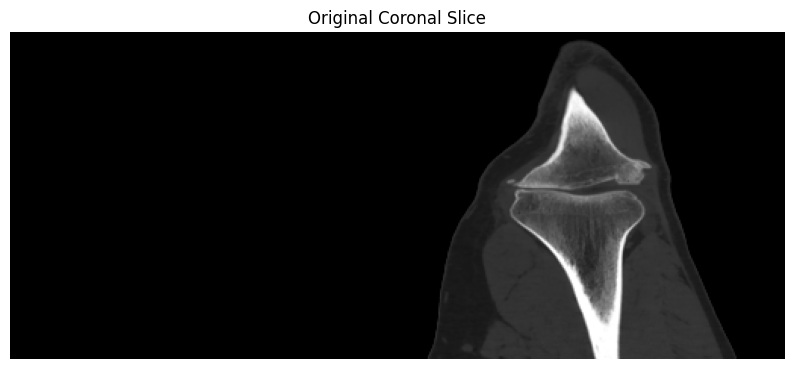

Segmenting knee CT...
Voxel spacing: [0.86914098 0.86914098 2.        ] mm
Expansion radius in voxels: [2.30112265 2.30112265 1.        ]
Voxel spacing: [0.86914098 0.86914098 2.        ] mm
Expansion radius in voxels: [4.6022453 4.6022453 2.       ]
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_original.nii.gz
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_expanded_2mm.nii.gz
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_expanded_4mm.nii.gz
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_randomized_1.nii.gz
Saved to /content/drive/MyDrive/segmentation_outputs/3702_left_knee.nii_tibia_randomized_2.nii.gz


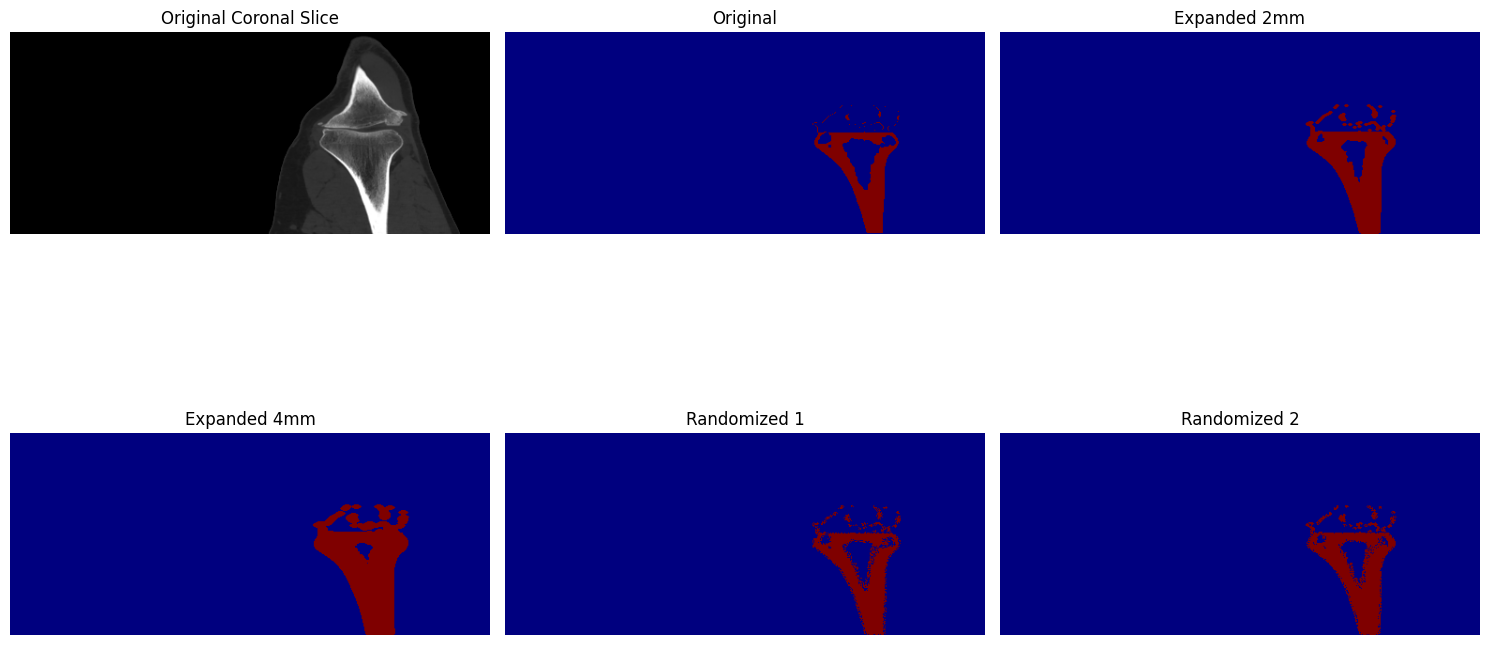

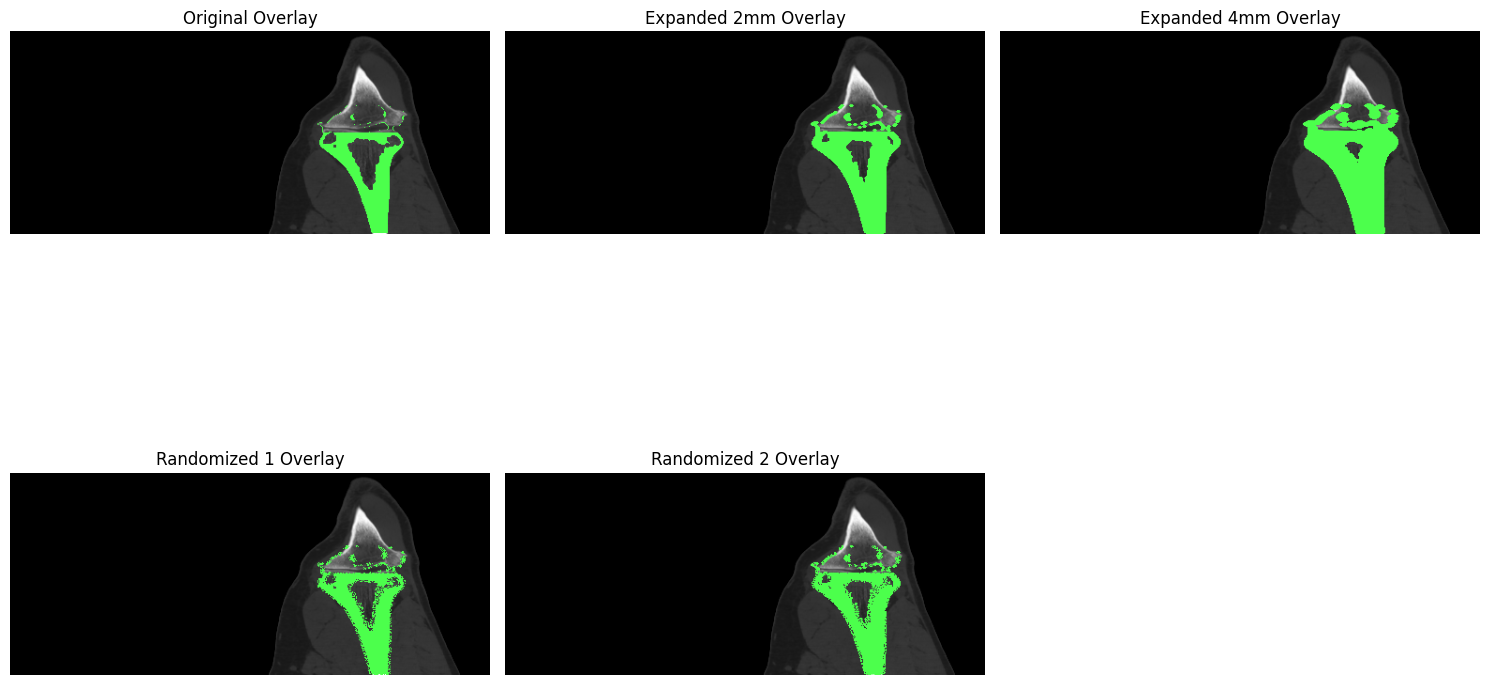

Original Tibia volume: 274610 voxels
Original Medial Lowest Point: [372 390 215]
Original Lateral Lowest Point: [255 402 215]
Expanded 2mm Tibia volume: 482253 voxels
Expanded 2mm Medial Lowest Point: [372 388 215]
Expanded 2mm Lateral Lowest Point: [253 401 215]
Expanded 4mm Tibia volume: 764361 voxels
Expanded 4mm Medial Lowest Point: [372 385 215]
Expanded 4mm Lateral Lowest Point: [250 401 215]
Randomized 1 Tibia volume: 378131 voxels
Randomized 1 Medial Lowest Point: [372 388 215]
Randomized 1 Lateral Lowest Point: [253 405 215]
Randomized 2 Tibia volume: 430045 voxels
Randomized 2 Medial Lowest Point: [372 388 215]
Randomized 2 Lateral Lowest Point: [253 401 215]


In [10]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, morphology, measure, feature

def create_spherical_structuring_element(radius_voxels, voxel_spacing):
    """Create a 3D spherical structuring element for dilation based on mm radius."""
    radius_voxels = np.array(radius_voxels)
    max_radius = int(np.ceil(np.max(radius_voxels)))
    grid = np.zeros((2 * max_radius + 1, 2 * max_radius + 1, 2 * max_radius + 1), dtype=bool)
    center = max_radius
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            for k in range(grid.shape[2]):
                mm_coords = np.array([(i - center) * voxel_spacing[0],
                                      (j - center) * voxel_spacing[1],
                                      (k - center) * voxel_spacing[2]])
                distance_mm = np.sqrt(np.sum(mm_coords ** 2))
                if distance_mm <= radius_voxels[0]:
                    grid[i, j, k] = True
    return grid

def expand_segmentation(segmentation_volume, img, expansion_mm=2.0, tibia_only=True):
    """Expand tibia mask by a specified distance in mm."""
    voxel_spacing = np.abs(np.diag(img.affine)[:3])
    print(f"Voxel spacing: {voxel_spacing} mm")
    radius_voxels = expansion_mm / voxel_spacing
    print(f"Expansion radius in voxels: {radius_voxels}")
    struct_element = create_spherical_structuring_element(radius_voxels, voxel_spacing)
    tibia_mask = segmentation_volume == 1
    expanded_tibia = ndimage.binary_dilation(tibia_mask, structure=struct_element)
    expanded_volume = np.zeros_like(segmentation_volume)
    expanded_volume[expanded_tibia] = 1
    return expanded_volume

def randomize_segmentation(original_volume, expanded_volume, random_factor=0.5, tibia_only=True):
    """Create a randomized tibia mask between original and expanded masks."""
    if not 0 <= random_factor <= 1:
        raise ValueError("random_factor must be between 0 and 1")

    randomized_volume = np.copy(original_volume)

    original_mask = original_volume == 1
    expanded_mask = expanded_volume == 1
    intermediate_region = expanded_mask & ~original_mask

    random_mask = np.random.random(intermediate_region.shape) < random_factor
    selected_intermediate = intermediate_region & random_mask

    randomized_volume[selected_intermediate] = 1

    return randomized_volume

def find_tibia_lowest_points(tibia_mask):
    """Find medial and lateral lowest points on the tibial surface."""
    surface = filters.sobel(tibia_mask) > 0
    surface_coords = np.where(surface)
    surface_points = np.array(list(zip(surface_coords[0], surface_coords[1], surface_coords[2])))

    if len(surface_points) == 0:
        return None, None

    x_coords = surface_points[:, 0]
    x_mid = (x_coords.min() + x_coords.max()) / 2
    medial_points = surface_points[x_coords >= x_mid]
    lateral_points = surface_points[x_coords < x_mid]

    medial_lowest = None
    lateral_lowest = None

    if len(medial_points) > 0:
        medial_lowest_idx = np.argmax(medial_points[:, 2])
        medial_lowest = medial_points[medial_lowest_idx]

    if len(lateral_points) > 0:
        lateral_lowest_idx = np.argmax(lateral_points[:, 2])
        lateral_lowest = lateral_points[lateral_lowest_idx]

    return medial_lowest, lateral_lowest

def save_nifti(volume, affine, header, output_path):
    """Save a volume as a NIfTI file."""
    nifti_img = nib.Nifti1Image(volume.astype(np.int16), affine, header)
    nifti_img.header.set_data_dtype(np.int16)
    nib.save(nifti_img, output_path)
    print(f"Saved to {output_path}")

def segment_knee(input_path, output_dir, expansion_mm_1=2.0, expansion_mm_2=4.0, random_factor_1=0.5, random_factor_2=0.75):
    """
    Segment tibia, generate masks, and find lowest points.

    Parameters:
    -----------
    input_path : str
        Path to the input NIfTI file
    output_dir : str
        Directory to save output NIfTI files
    expansion_mm_1 : float, optional
        First expansion distance in mm (default: 2.0)
    expansion_mm_2 : float, optional
        Second expansion distance in mm (default: 4.0)
    random_factor_1 : float, optional
        Random factor for first randomized mask (default: 0.5)
    random_factor_2 : float, optional
        Random factor for second randomized mask (default: 0.75)

    Returns:
    --------
    dict
        Dictionary of mask names and their lowest points' coordinates
    """
    os.makedirs(output_dir, exist_ok=True)

    print(f"Loading image from {input_path}")
    img = nib.load(input_path)
    data = img.get_fdata()

    print(f"Image shape: {data.shape}")
    print(f"Image data type: {data.dtype}")
    value_range = [np.min(data), np.max(data)]
    print(f"Value range: {value_range}")

    coronal_idx = data.shape[1] // 2
    coronal_slice = data[:, coronal_idx, :]

    plt.figure(figsize=(10, 10))
    plt.imshow(coronal_slice.T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')
    plt.show()

    segmentation_volume = np.zeros_like(data)
    bone_threshold = 200

    print("Segmenting knee CT...")
    start_slice = int(data.shape[1] * 0.2)
    end_slice = int(data.shape[1] * 0.8)

    for i in range(start_slice, end_slice):
        slice_data = data[:, i, :]
        if np.max(slice_data) < bone_threshold:
            continue
        bone_mask = slice_data > bone_threshold
        bone_mask = morphology.remove_small_objects(bone_mask, min_size=50)
        bone_mask = morphology.binary_closing(bone_mask, morphology.disk(2))
        height = slice_data.shape[1]
        vertical_profile = np.sum(bone_mask, axis=0)
        smooth_profile = ndimage.gaussian_filter1d(vertical_profile, sigma=5)
        middle_start = height // 3
        middle_end = 2 * height // 3
        middle_profile = smooth_profile[middle_start:middle_end]
        if len(middle_profile) > 5:
            min_indices = []
            for j in range(2, len(middle_profile) - 2):
                if middle_profile[j] < middle_profile[j-1] and middle_profile[j] < middle_profile[j+1]:
                    min_indices.append(j)
            if min_indices:
                joint_idx = min_indices[np.argmin([middle_profile[j] for j in min_indices])]
                joint_position = middle_start + joint_idx
                femur_mask = bone_mask.copy()
                femur_mask[:, joint_position:] = False
                tibia_mask = bone_mask.copy()
                tibia_mask[:, :joint_position] = False
            else:
                mid_point = height // 2
                femur_mask = bone_mask.copy()
                femur_mask[:, mid_point:] = False
                tibia_mask = bone_mask.copy()
                tibia_mask[:, :mid_point] = False
        else:
            mid_point = height // 2
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False
        femur_mask = morphology.remove_small_objects(femur_mask, min_size=100)
        tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=100)
        segmentation_volume[:, i, :][tibia_mask] = 1
        segmentation_volume[:, i, :][femur_mask] = 2

    tibia_seg = segmentation_volume == 1
    femur_seg = segmentation_volume == 2
    struct_element = np.ones((3, 3, 3))
    tibia_seg = ndimage.binary_fill_holes(tibia_seg)
    femur_seg = ndimage.binary_fill_holes(femur_seg)
    tibia_seg = ndimage.binary_closing(tibia_seg, structure=struct_element)
    femur_seg = ndimage.binary_closing(femur_seg, structure=struct_element)
    tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
    femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)
    segmentation_volume = np.zeros_like(data)
    segmentation_volume[tibia_seg] = 1
    segmentation_volume[femur_seg] = 2

    tibia_volume = np.sum(tibia_seg)
    femur_volume = np.sum(femur_seg)

    if tibia_volume < 1000 or femur_volume < 1000:
        print("Warning: Insufficient bone volume detected. Applying fallback method...")
        segmentation_volume = np.zeros_like(data)
        for i in range(start_slice, end_slice):
            slice_data = data[:, i, :]
            bone_mask = slice_data > 150
            height = slice_data.shape[1]
            mid_point = height // 2
            femur_mask = bone_mask.copy()
            femur_mask[:, mid_point:] = False
            femur_mask = morphology.remove_small_objects(femur_mask, min_size=50)
            tibia_mask = bone_mask.copy()
            tibia_mask[:, :mid_point] = False
            tibia_mask = morphology.remove_small_objects(tibia_mask, min_size=50)
            segmentation_volume[:, i, :][tibia_mask] = 1
            segmentation_volume[:, i, :][femur_mask] = 2
        tibia_seg = segmentation_volume == 1
        femur_seg = segmentation_volume == 2
        tibia_seg = ndimage.binary_closing(tibia_seg, structure=np.ones((5, 5, 5)))
        femur_seg = ndimage.binary_closing(femur_seg, structure=np.ones((5, 5, 5)))
        tibia_seg = ndimage.binary_fill_holes(tibia_seg)
        femur_seg = ndimage.binary_fill_holes(femur_seg)
        tibia_seg = morphology.remove_small_objects(tibia_seg, min_size=1000)
        femur_seg = morphology.remove_small_objects(femur_seg, min_size=1000)
        segmentation_volume = np.zeros_like(data)
        segmentation_volume[tibia_seg] = 1
        segmentation_volume[femur_seg] = 2

    original_tibia = np.zeros_like(data)
    original_tibia[segmentation_volume == 1] = 1
    expanded_tibia_2mm = expand_segmentation(original_tibia, img, expansion_mm_1)
    expanded_tibia_4mm = expand_segmentation(original_tibia, img, expansion_mm_2)
    randomized_tibia_1 = randomize_segmentation(original_tibia, expanded_tibia_2mm, random_factor_1)
    randomized_tibia_2 = randomize_segmentation(original_tibia, expanded_tibia_2mm, random_factor_2)

    base_name = os.path.splitext(os.path.basename(input_path))[0]
    save_nifti(original_tibia, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_original.nii.gz"))
    save_nifti(expanded_tibia_2mm, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_expanded_2mm.nii.gz"))
    save_nifti(expanded_tibia_4mm, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_expanded_4mm.nii.gz"))
    save_nifti(randomized_tibia_1, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_randomized_1.nii.gz"))
    save_nifti(randomized_tibia_2, img.affine, img.header, os.path.join(output_dir, f"{base_name}_tibia_randomized_2.nii.gz"))

    masks = {
        "Original": original_tibia,
        "Expanded 2mm": expanded_tibia_2mm,
        "Expanded 4mm": expanded_tibia_4mm,
        "Randomized 1": randomized_tibia_1,
        "Randomized 2": randomized_tibia_2
    }
    lowest_points = {}
    for name, mask in masks.items():
        medial, lateral = find_tibia_lowest_points(mask)
        lowest_points[name] = {"Medial": medial, "Lateral": lateral}

    mid_slice = data.shape[1] // 2
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(data[:, mid_slice, :].T, cmap='gray', vmin=-300, vmax=1500)
    plt.title('Original Coronal Slice')
    plt.axis('off')
    for i, (name, mask) in enumerate(masks.items(), 2):
        plt.subplot(2, 3, i)
        plt.imshow(mask[:, mid_slice, :].T, cmap='jet')
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 10))
    for i, (name, mask) in enumerate(masks.items(), 1):
        plt.subplot(2, 3, i)
        overlay = np.zeros((*data[:, mid_slice, :].T.shape, 3))
        orig_slice = data[:, mid_slice, :].T
        orig_norm = np.clip(orig_slice, -300, 1500)
        orig_norm = (orig_norm - (-300)) / (1500 - (-300))
        overlay[:, :, 0] = orig_norm
        overlay[:, :, 1] = orig_norm
        overlay[:, :, 2] = orig_norm
        tibia_mask = mask[:, mid_slice, :].T == 1
        overlay[tibia_mask, 0] = 0.3
        overlay[tibia_mask, 1] = 1.0
        overlay[tibia_mask, 2] = 0.3
        plt.imshow(overlay)
        plt.title(f"{name} Overlay")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    for name, mask in masks.items():
        volume = np.sum(mask == 1)
        print(f"{name} Tibia volume: {volume} voxels")
        medial = lowest_points[name]["Medial"]
        lateral = lowest_points[name]["Lateral"]
        print(f"{name} Medial Lowest Point: {medial if medial is not None else 'Not found'}")
        print(f"{name} Lateral Lowest Point: {lateral if lateral is not None else 'Not found'}")

    return lowest_points

if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/3702_left_knee.nii.gz"
    output_dir = "/content/drive/MyDrive/segmentation_outputs"

    if not os.path.exists(input_path):
        print(f"Error: Input file {input_path} does not exist.")
    else:
        lowest_points = segment_knee(input_path, output_dir, expansion_mm_1=2.0, expansion_mm_2=4.0, random_factor_1=0.5, random_factor_2=0.75)